# Text Analysis of Risk Analysis Reports

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from gensim.models import Word2Vec
from wordcloud import WordCloud
import pickle
import os
from webutils.analysis_utils import compute_keyness
from nltk.util import ngrams

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emilykruger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emilykruger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilykruger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Full Corpus

## TF-IDF Analysis

In [2]:
#load data set
df = pd.read_csv('../results/tfidf_enriched.csv').drop('Unnamed: 0', axis=1)
df.head(5)

,Filename,Top 10 TF-IDF Words,Year,Region
0,fran_q1_2011.txt,"[('border', 0.33789811555387134), ('frontex', ...",2011,Global
1,afic_2017.txt,"[('firearm', 0.49872260974129107), ('weapon', ...",2017,Africa
2,2023.11.16_frontex-general-industry-days-innov...,"[('industry', 0.36217134658434197), ('innovati...",2023,Other
3,ara-2022-public-web.txt,"[('afic', 0.5450466305625354), ('migrant', 0.1...",2022,Other
4,afic_2016.txt,"[('afic', 0.4951977970733415), ('niger', 0.257...",2016,Africa


### TF-IDF Scores per Region

In [3]:
# Display settings for bar plots
sns.set(rc={'figure.figsize': (20, 10)})
#color palette
sns.color_palette('magma', as_cmap=True)

#other
sns.set_context('paper')
sns.set_style('ticks') 
sns.axes_style('ticks')
plt.rcParams.update({'axes.labelsize': 20, 'axes.titlesize': 25,'axes.titlesize': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

#### One Barplot per Region

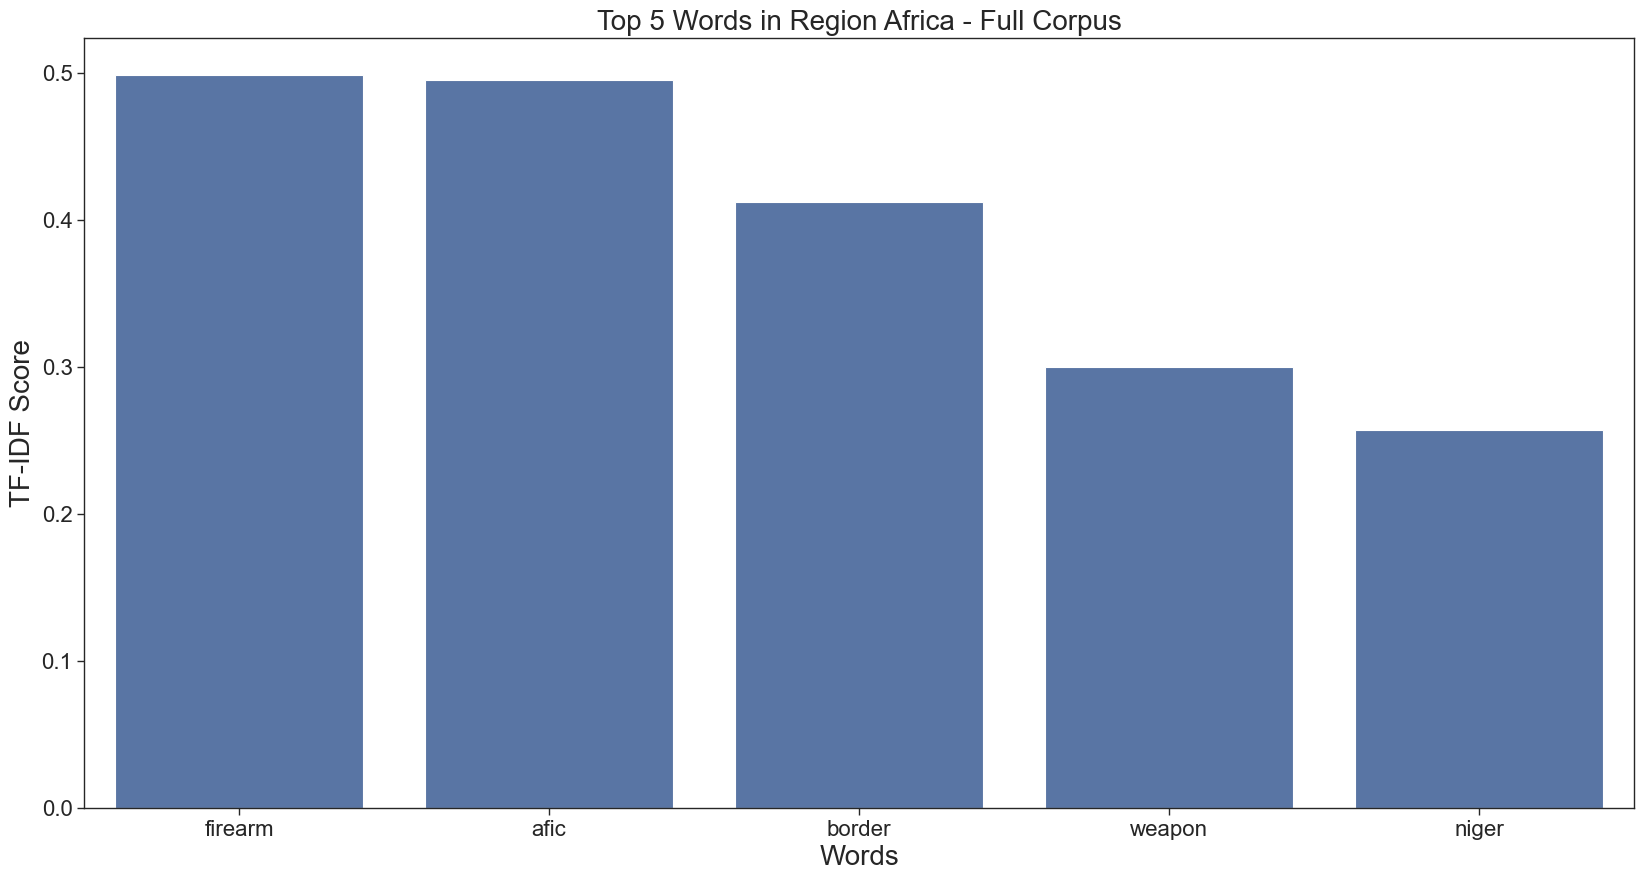

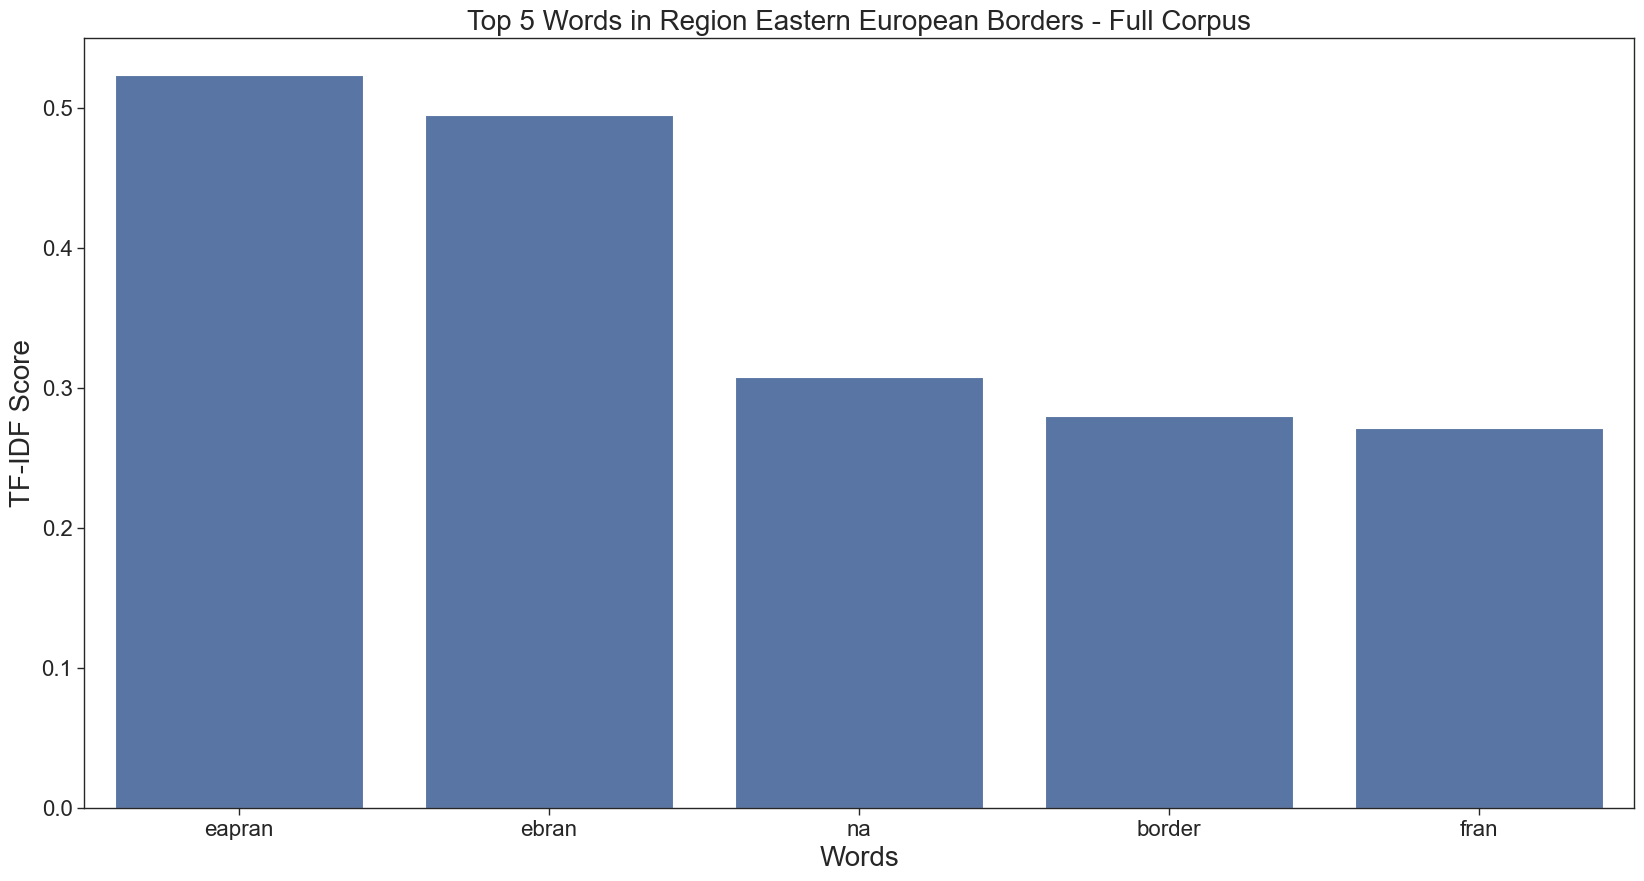

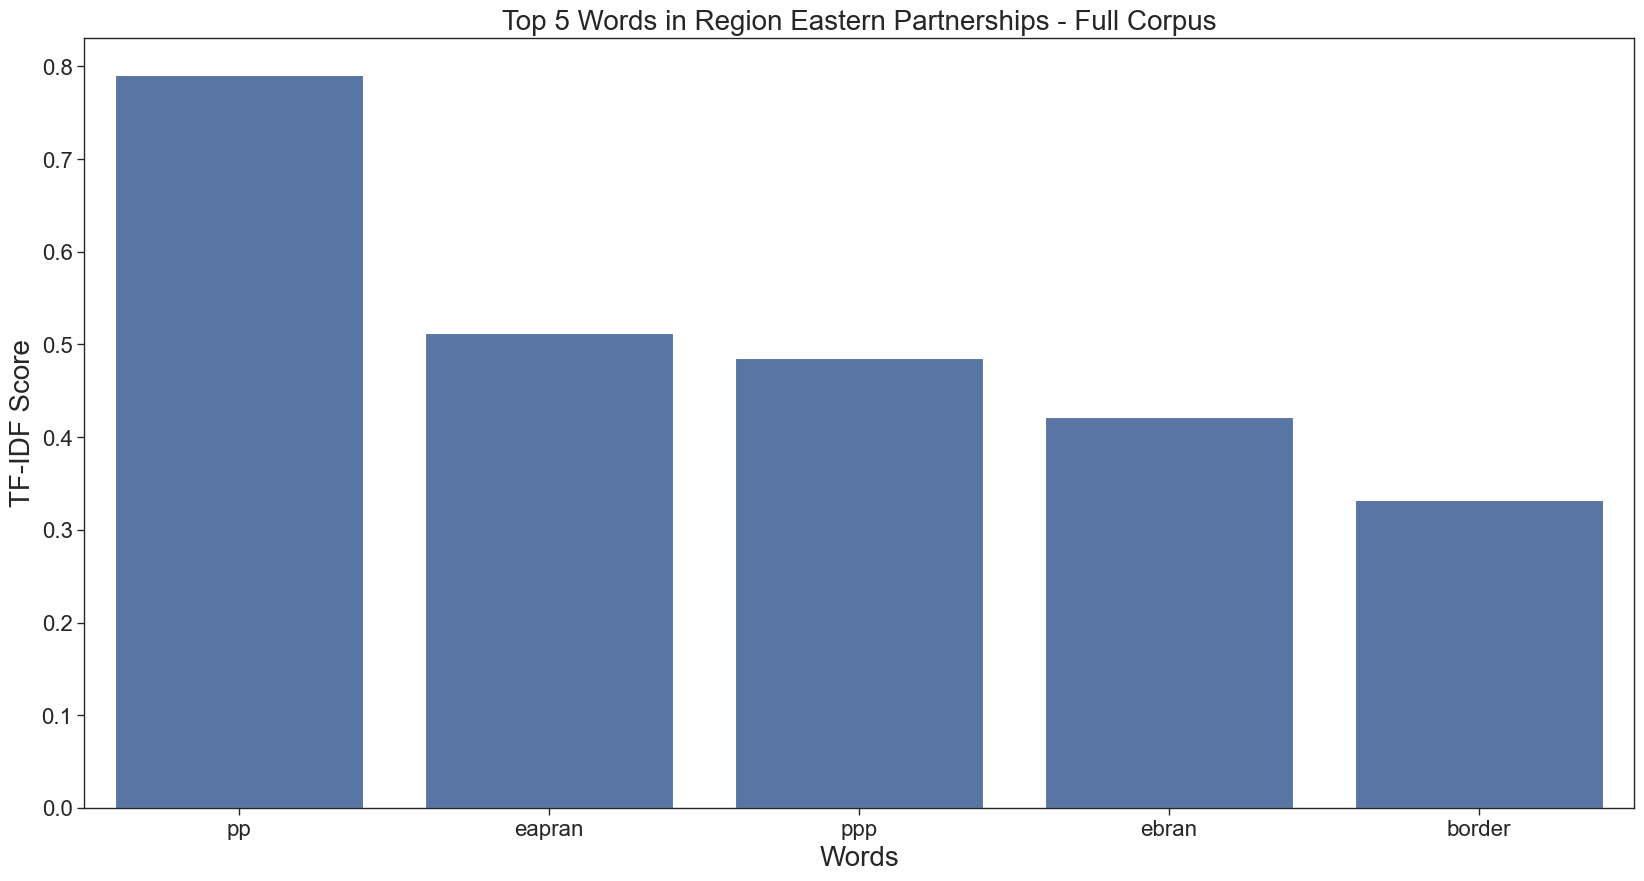

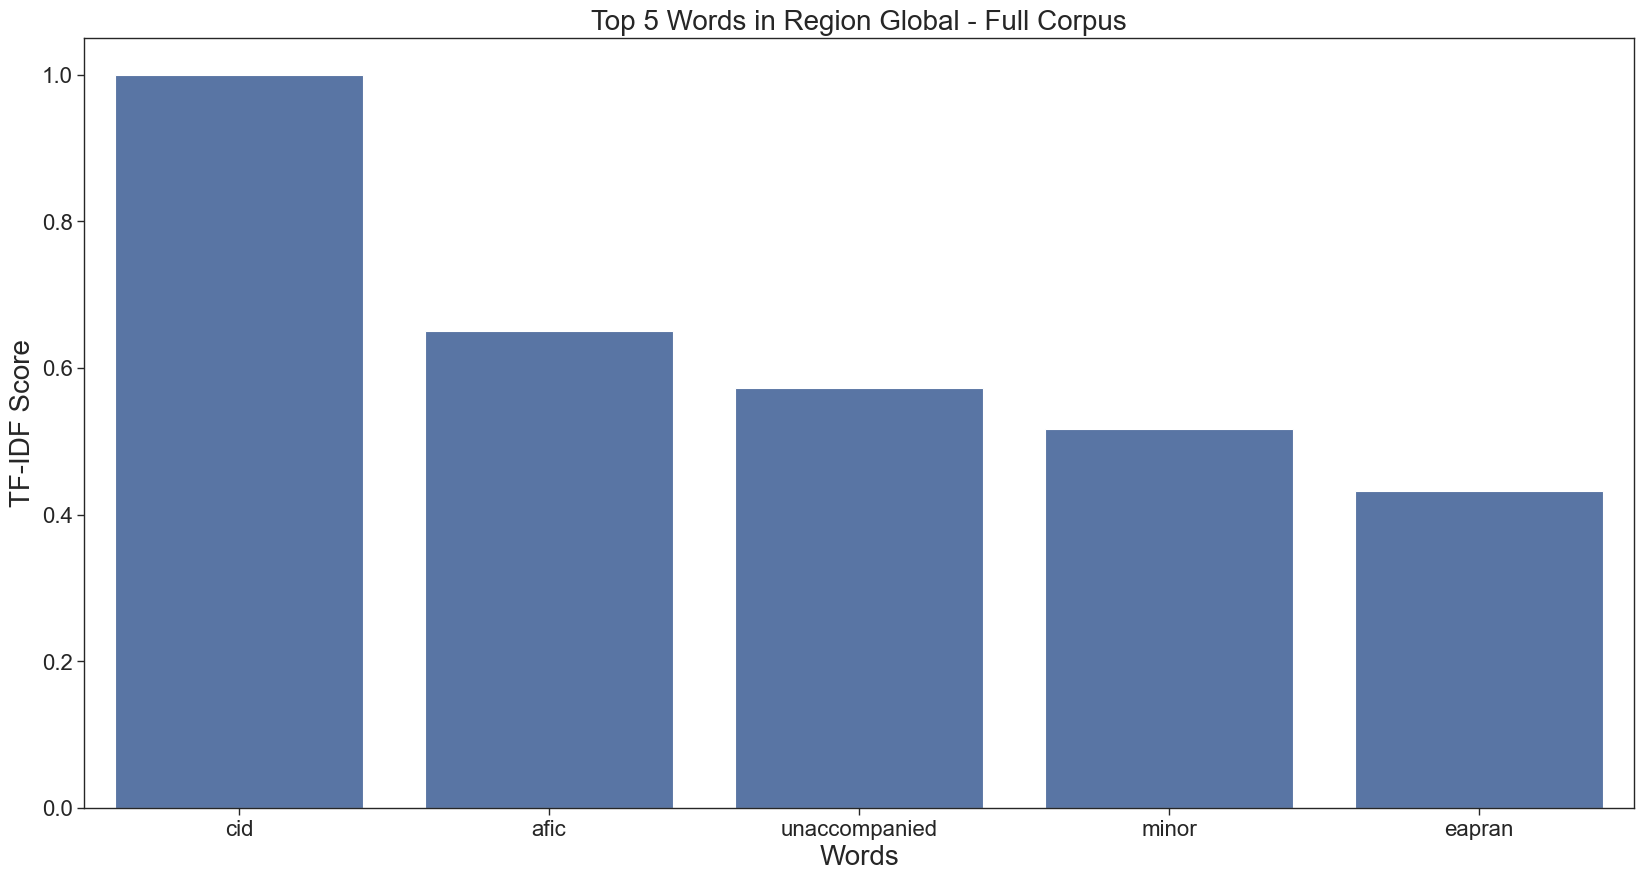

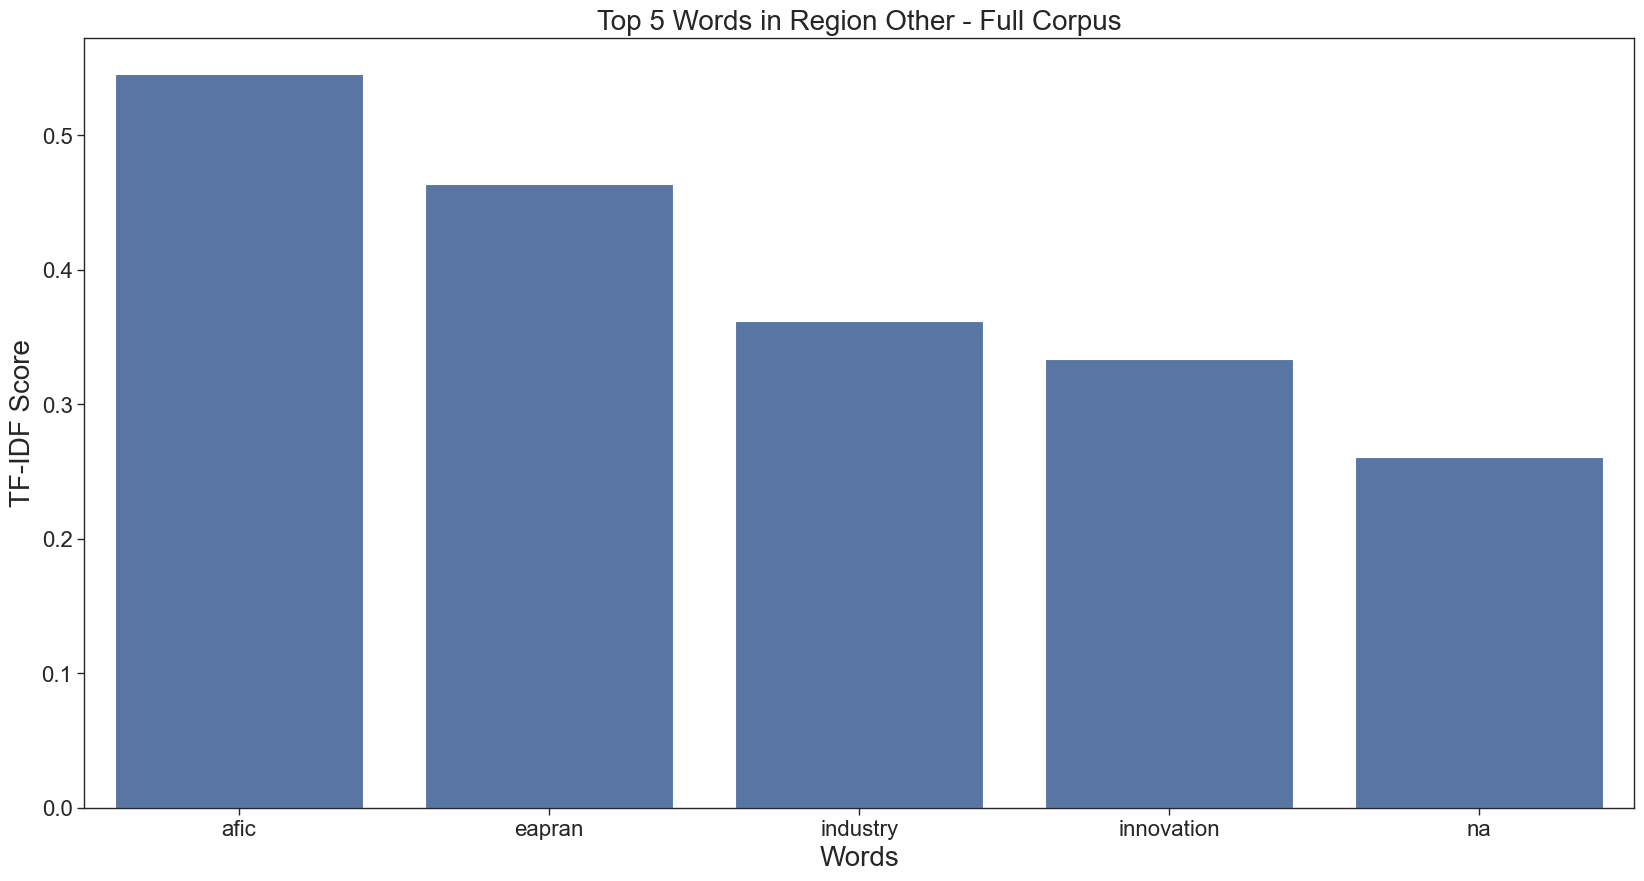

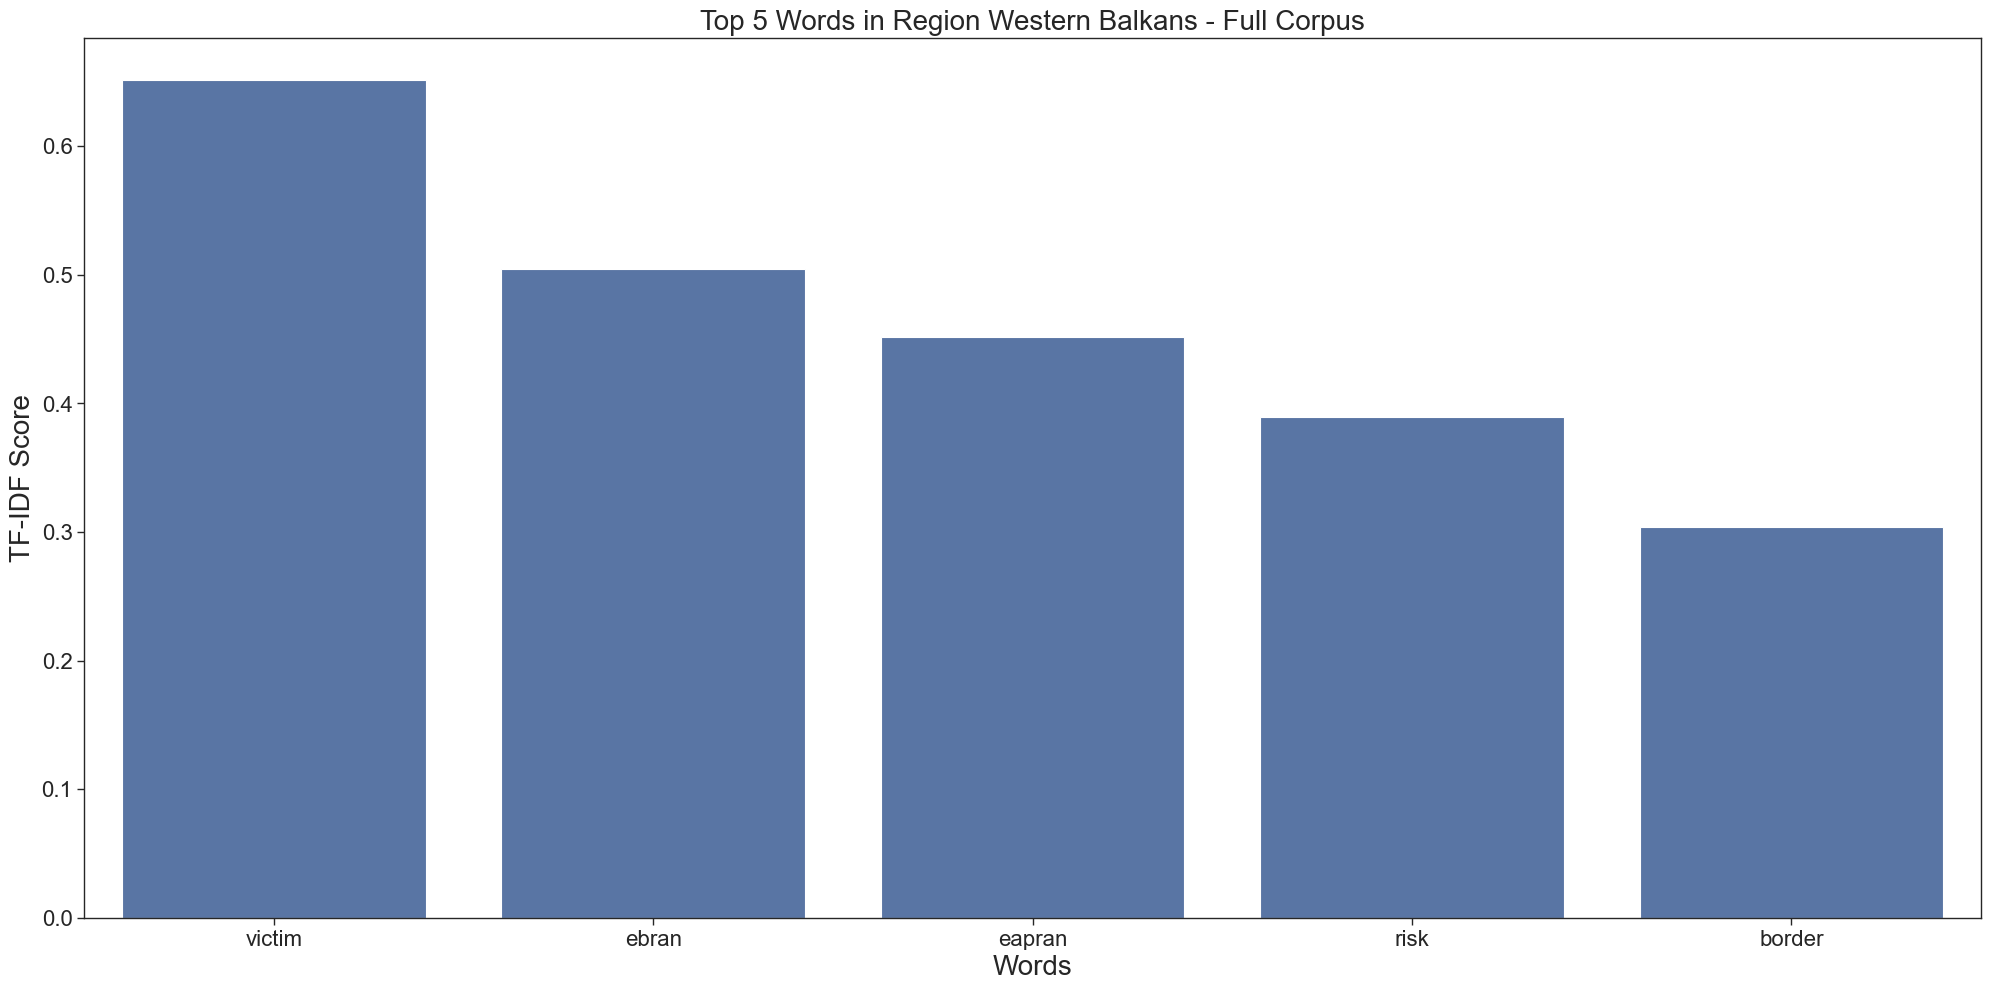

In [4]:
# Group by 'Region' and concatenate all TF-IDF tuples
grouped_region = df.groupby('Region')['Top 10 TF-IDF Words'].sum()

# Convert grouped_region.items() to a list of tuples
grouped_region_items = list(grouped_region.items())

for i, (region, tfidf_tuples_str) in enumerate(grouped_region_items):
    # Use regular expressions to extract tuples from string
    tfidf_tuples_str_list = re.findall(r"\('(.*?)', (.*?)\)", tfidf_tuples_str)
    
    # Convert string representation of score to float
    tfidf_tuples = [(word, float(score)) for word, score in tfidf_tuples_str_list]
    
    # Filter out tuples that do not have 2 elements
    filtered_tuples = [t for t in tfidf_tuples if len(t) == 2]
    
    # Sort by TF-IDF score and get top 5
    top_5 = Counter(dict(filtered_tuples)).most_common(5)
    # Check if top_5 is not empty
    if top_5:
        # Prepare data for seaborn
        words, scores = zip(*top_5)
        data = pd.DataFrame({'Words': words, 'TF-IDF Score': scores})
        
        # Create a new figure for each region
        plt.figure(i)
        
        # Plot using seaborn
        sns.barplot(x='Words', y='TF-IDF Score', data=data)
        plt.title(f'Top 5 Words in Region {region} - Full Corpus')
        plt.xlabel('Words')
        plt.ylabel('TF-IDF Score')

plt.tight_layout()
plt.show()

#### One Combined Barplot with Region as Legend

/var/folders/fd/qf26p3js3x32_9_qwsb841y80000gn/T/ipykernel_74292/1268093997.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, data], ignore_index=True)


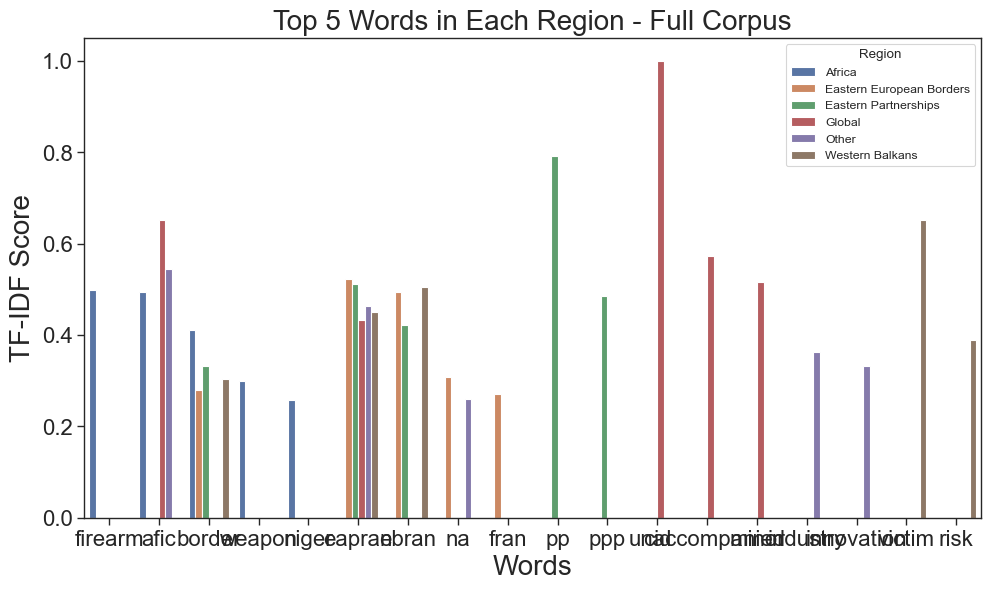

In [5]:
# Prepare an empty DataFrame for all data
all_data = pd.DataFrame(columns=['Region', 'Words', 'TF-IDF Score'])

for region, tfidf_tuples_str in grouped_region_items:
    # Use regular expressions to extract tuples from string
    tfidf_tuples_str_list = re.findall(r"\('(.*?)', (.*?)\)", tfidf_tuples_str)
    
    # Convert string representation of score to float
    tfidf_tuples = [(word, float(score)) for word, score in tfidf_tuples_str_list]
    
    # Filter out tuples that do not have 2 elements
    filtered_tuples = [t for t in tfidf_tuples if len(t) == 2]
    
    # Sort by TF-IDF score and get top 5
    top_5 = Counter(dict(filtered_tuples)).most_common(5)
    
    # Check if top_5 is not empty
    if top_5:
        # Prepare data for seaborn
        words, scores = zip(*top_5)
        data = pd.DataFrame({'Region': [region]*len(words), 'Words': words, 'TF-IDF Score': scores})
        
        # Append data to all_data
        all_data = pd.concat([all_data, data], ignore_index=True)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Words', y='TF-IDF Score', hue='Region', data=all_data)
plt.title('Top 5 Words in Each Region - Full Corpus')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.tight_layout()
plt.show()

#### Heatmap - Regions

In [6]:
# Display settings for heatmap
plt.rcParams.update({'axes.labelsize': 10, 'axes.titlesize': 15,'axes.titlesize': 10, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

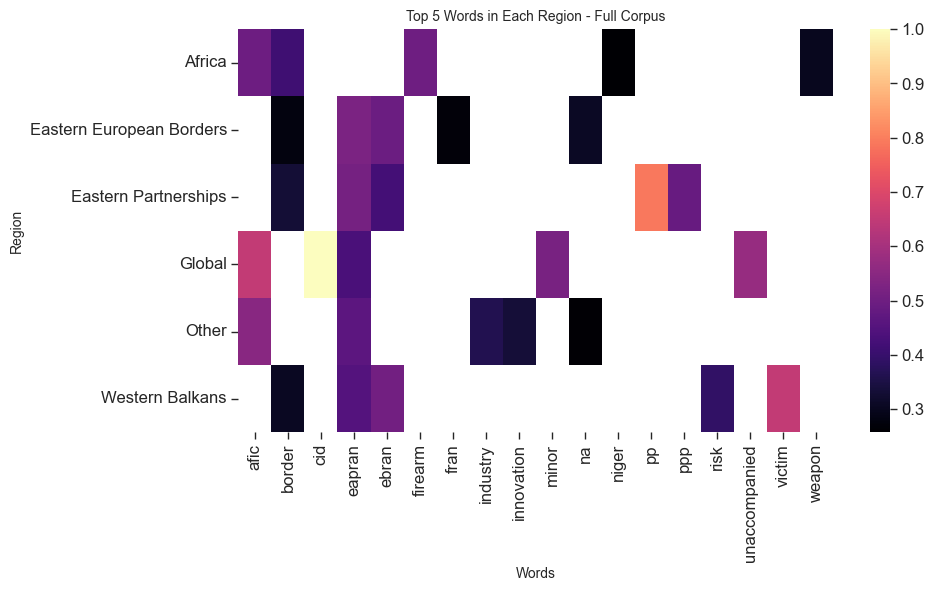

In [7]:
# Pivot the data for the heatmap
heatmap_data = all_data.pivot(index='Region', columns='Words', values='TF-IDF Score')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='magma')
plt.title('Top 5 Words in Each Region - Full Corpus')
plt.xlabel('Words')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

    Out of all three visualization methods, heatmap is the best (visually), but results are not very insightful.

### TF-IDF Scores per Year

#### One Barplot per Year

In [8]:
# Display settings for bar plots
sns.set(rc={'figure.figsize': (20, 10)})
#color palette
sns.color_palette('magma', as_cmap=True)

#other
sns.set_context('paper')
sns.set_style('ticks') 
sns.axes_style('ticks')
plt.rcParams.update({'axes.labelsize': 20, 'axes.titlesize': 25,'axes.titlesize': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

/var/folders/fd/qf26p3js3x32_9_qwsb841y80000gn/T/ipykernel_74292/4159183781.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data_year = pd.concat([all_data_year, data], ignore_index=True)


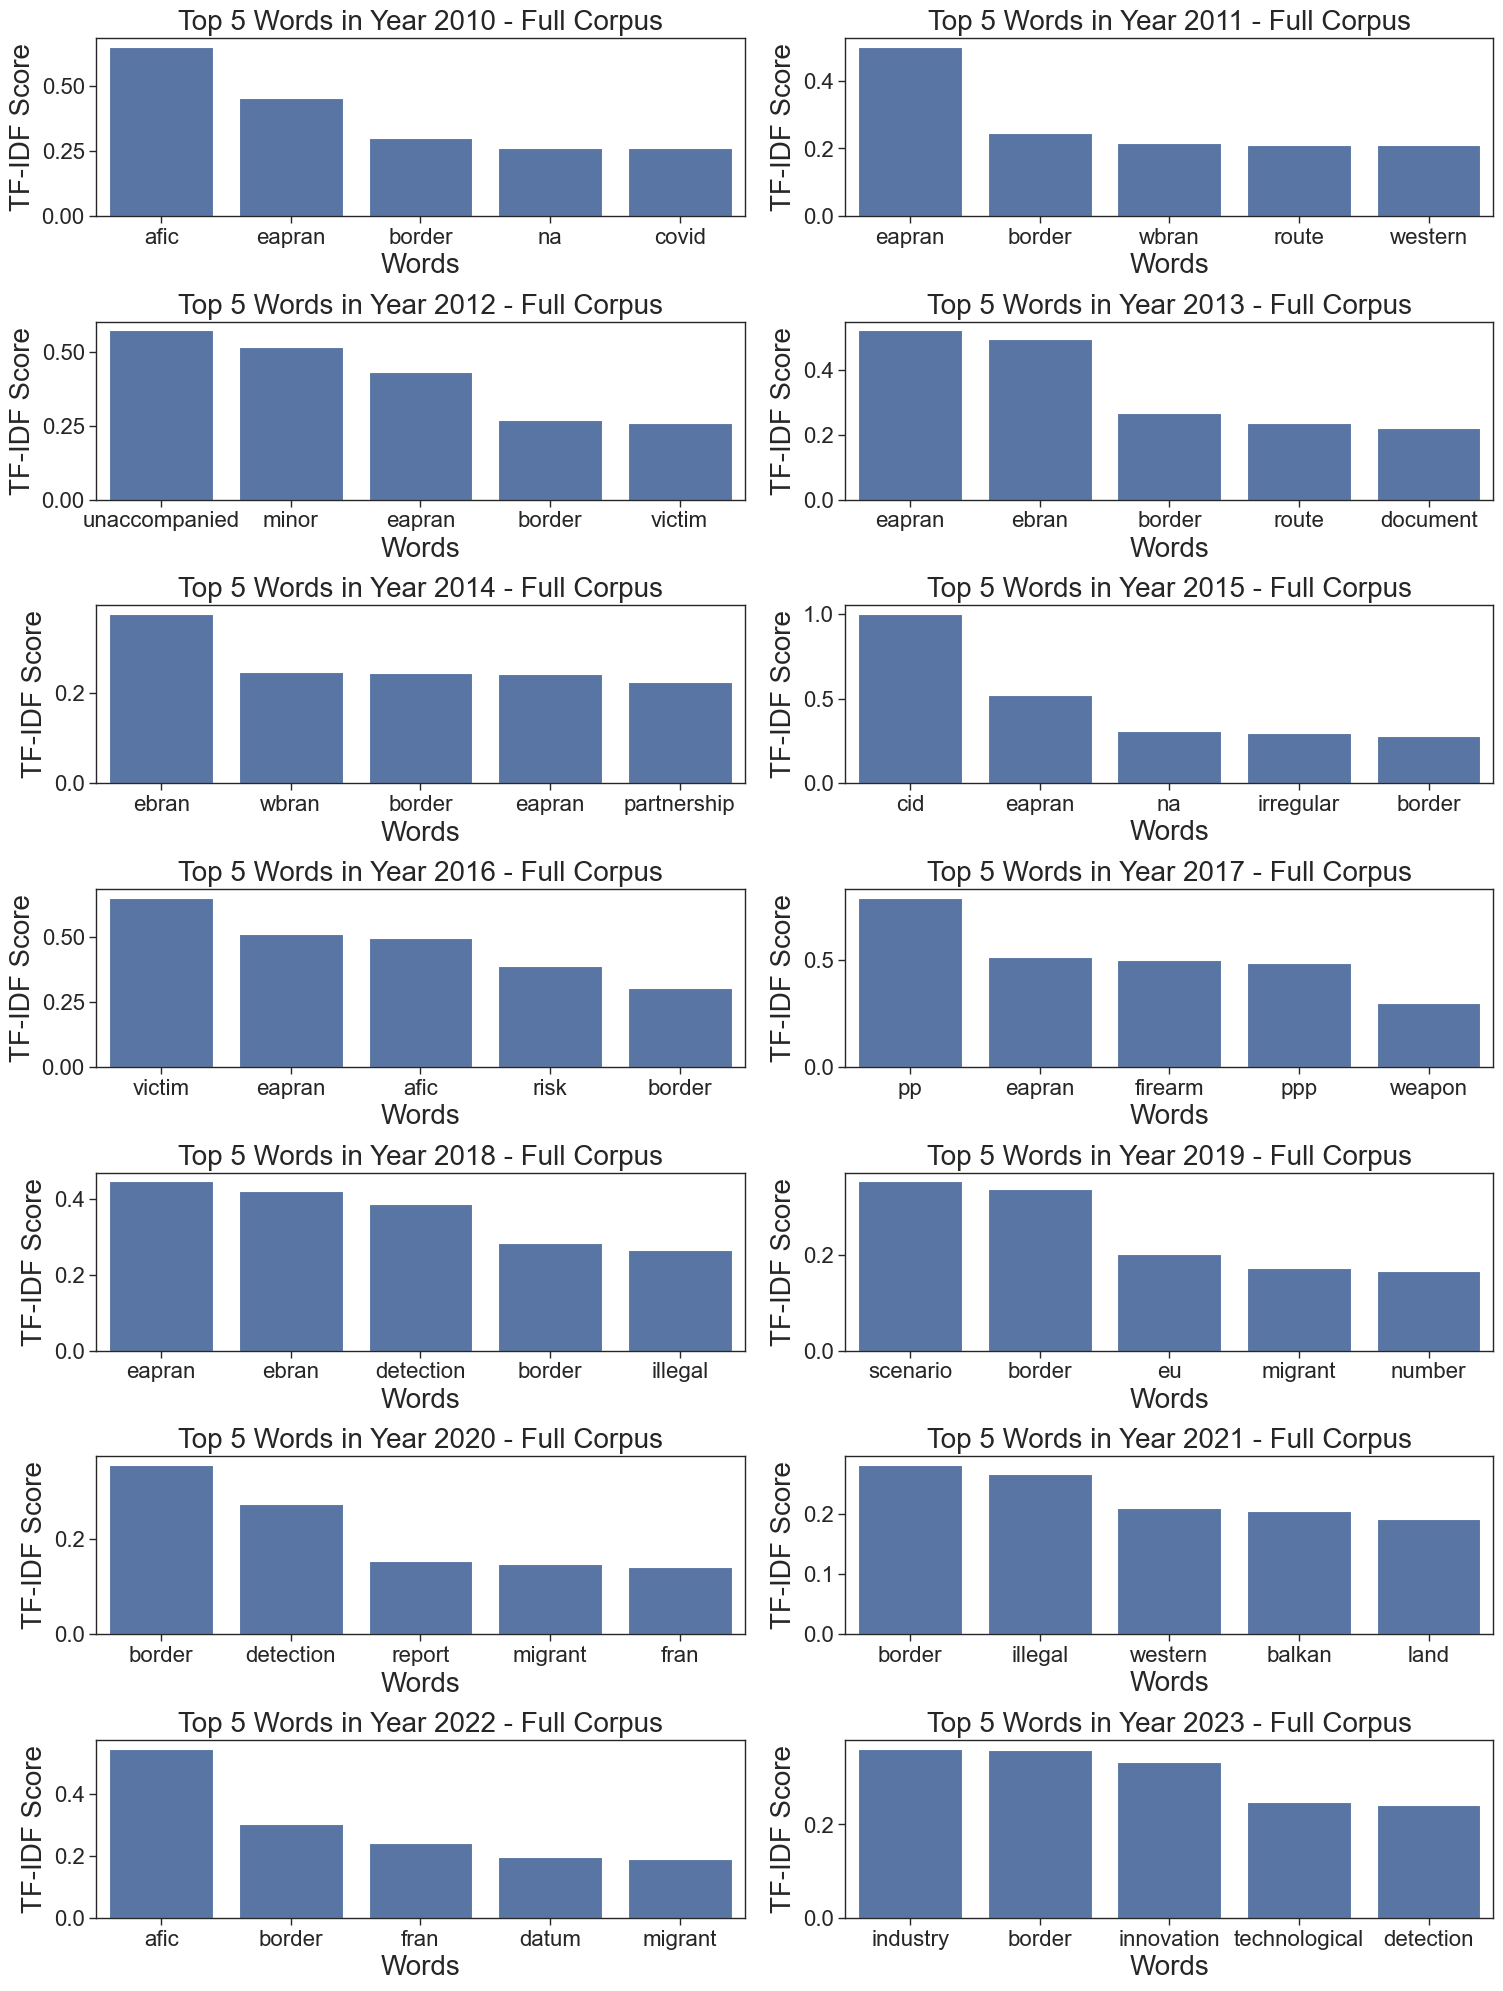

In [9]:
# Prepare an empty DataFrame for all data
all_data_year = pd.DataFrame(columns=['Year', 'Words', 'TF-IDF Score'])
# Group by 'year' and concatenate all TF-IDF tuples
grouped_year = df.groupby('Year')['Top 10 TF-IDF Words'].sum()

# Convert grouped_year.items() to a list of tuples
grouped_year_items = list(grouped_year.items())

# Create a figure to hold the subplots
fig = plt.figure(figsize=(15, 20))

for i, (year, tfidf_tuples_str) in enumerate(grouped_year_items):
    # Use regular expressions to extract tuples from string
    tfidf_tuples_str_list = re.findall(r"\('(.*?)', (.*?)\)", tfidf_tuples_str)
    
    # Convert string representation of score to float
    tfidf_tuples = [(word, float(score)) for word, score in tfidf_tuples_str_list]
    
    # Filter out tuples that do not have 2 elements
    filtered_tuples = [t for t in tfidf_tuples if len(t) == 2]
    
    # Sort by TF-IDF score and get top 5
    top_5 = Counter(dict(filtered_tuples)).most_common(5)
    # Check if top_5 is not empty
    if top_5:
        # Prepare data for seaborn
        words, scores = zip(*top_5)
        data = pd.DataFrame({'Year': [year]*len(words), 'Words': words, 'TF-IDF Score': scores})
        # Append data to all_data
        all_data_year = pd.concat([all_data_year, data], ignore_index=True)
        
        # Create a new subplot in the grid
        ax = fig.add_subplot(7, 2, i+1)
        
        # Plot using seaborn
        sns.barplot(x='Words', y='TF-IDF Score', data=data, ax=ax)
        ax.set_title(f'Top 5 Words in Year {year} - Full Corpus')
        ax.set_xlabel('Words')
        ax.set_ylabel('TF-IDF Score')

plt.tight_layout()
plt.show()

#### Heatmap - Years

In [10]:
all_data_year = all_data_year[all_data_year['TF-IDF Score'] >= 0.3]

In [11]:
#Display settings for heatmap
sns.set(rc={'figure.figsize': (100, 50)})
plt.rcParams.update({'axes.labelsize': 10, 'axes.titlesize': 15,'axes.titlesize': 10, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

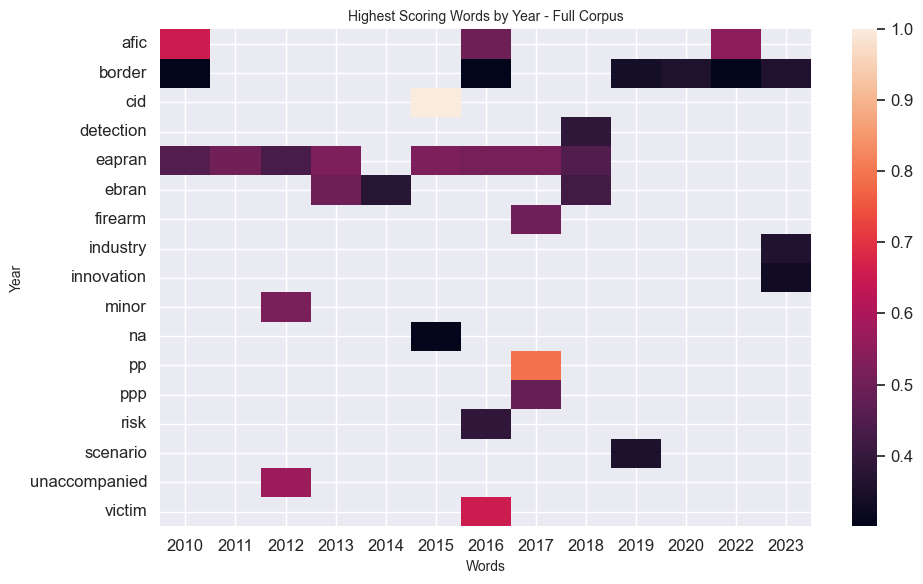

In [12]:
# Pivot the data for the heatmap
heatmap_data = all_data_year.pivot(index='Words', columns='Year', values='TF-IDF Score')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data)
plt.title('Highest Scoring Words by Year - Full Corpus')
plt.xlabel('Words')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

## Word2Vec Analysis

In [13]:
#load word2vec model from models folder
model_full = Word2Vec.load('../model/word2vec_model_full.model')

### Most Similar Words

In [14]:
#find most similar words to specific keywords
similar_migrant = model_full.wv.most_similar('migrant', topn=5)
similar_refugee = model_full.wv.most_similar('refugee', topn=5)
similar_migration =  model_full.wv.most_similar('migration', topn=5)
similar_asylum = model_full.wv.most_similar('asylum', topn=5)
similar_border = model_full.wv.most_similar('border', topn=5)
similar_eu = model_full.wv.most_similar('eu', topn=5)

In [15]:
# print each keyword and most similar words
print('Most similar words to migrant:', similar_migrant)
print('Most similar words to refugee:', similar_refugee)
print('Most similar words to migration:', similar_migration)
print('Most similar words to asylum:', similar_asylum)
print('Most similar words to border:', similar_border)
print('Most similar words to eu:', similar_eu)

Most similar words to migrant: [('flowpressure', 0.658435583114624), ('croatianser', 0.6479498744010925), ('nonre', 0.6451206803321838), ('subsaha', 0.6448805928230286), ('organising', 0.643852710723877)]
Most similar words to refugee: [('asylumseeker', 0.5903377532958984), ('nonsyrian', 0.5819748640060425), ('unhcr', 0.5806534290313721), ('idps', 0.5801869034767151), ('refuge', 0.5757936835289001)]
Most similar words to migration: [('migra', 0.6586243510246277), ('gration', 0.6433038115501404), ('irregular', 0.638828456401825), ('migratory', 0.6100254058837891), ('irreg', 0.5988134741783142)]
Most similar words to asylum: [('lum', 0.6877322196960449), ('seeker', 0.6868922114372253), ('asy', 0.6817116141319275), ('implicitly', 0.6594690680503845), ('abscond', 0.6549170613288879)]
Most similar words to border: [('romanianmoldovan', 0.6652474999427795), ('categorise', 0.661337673664093), ('bias', 0.6588352918624878), ('borders', 0.6579846739768982), ('funded', 0.6562109589576721)]
Most s

## WordCloud

In [16]:
#load corpus file from corpus folder with pickle
with open('../data/corpus/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

# Convert list of lists into a single list
corpus_flat = [word for sublist in corpus for word in sublist]

#create a wordcloud of all images in the corpus
wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(' '.join(corpus_flat))

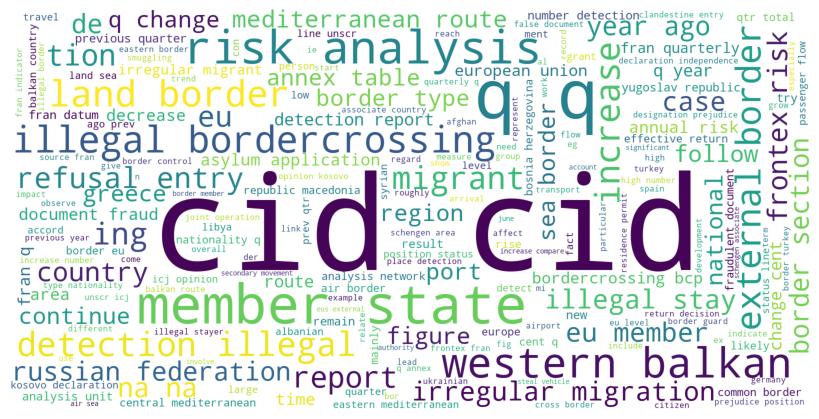

In [17]:
#plot wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Annual Risk Analysis Reports Only

## WordCloud

In [18]:
#load corpus file from corpus folder with pickle
with open('../data/corpus/corpus_annual_raw.pkl', 'rb') as f:
    corpus_annual_raw = pickle.load(f)

# Convert list of lists into a single list
corpus_annual_flat = [word for sublist in corpus_annual_raw for word in sublist]

#create a wordcloud of all images in the corpus
wordcloud_annual = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(' '.join(corpus_annual_flat))

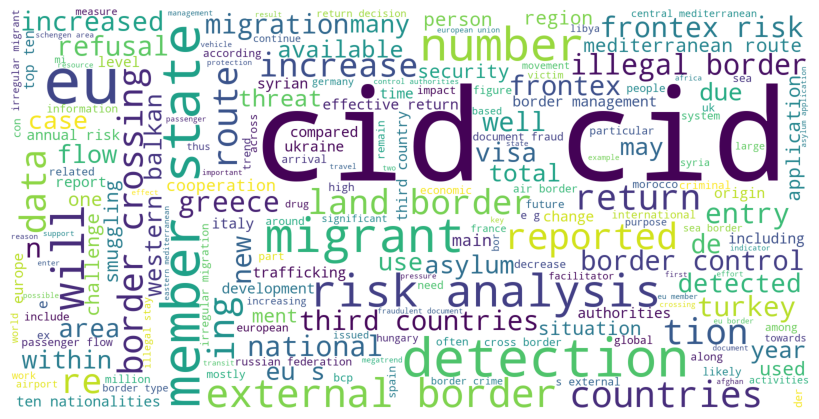

In [19]:
#plot wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_annual)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [20]:
#save wordcloud to results folder
wordcloud_annual.to_file('../results/wordcloud_annual.png')

## Word2Vec

In [39]:
#load word2vec model from models folder
model_annual = Word2Vec.load('../model/word2vec_model_annual.model')

In [40]:
#find most similar words to specific keywords
similar_migrant_annual = model_annual.wv.most_similar('migrant', topn=5)
similar_refugee_annual = model_annual.wv.most_similar('refugee', topn=5)
similar_migration_annual =  model_annual.wv.most_similar('migration', topn=5)
similar_asylum_annual = model_annual.wv.most_similar('asylum', topn=5)
similar_border_annual = model_annual.wv.most_similar('border', topn=5)
similar_eu_annual = model_annual.wv.most_similar('eu', topn=5)
similar_security_annual = model_annual.wv.most_similar('security', topn=5)
similar_threat_annual = model_annual.wv.most_similar('threat', topn=5)

In [41]:
# print each keyword and most similar wordsprint('Most similar words to migrant:', similar_migrant_annual)
print('Most similar words to refugee:', similar_refugee_annual)
print('Most similar words to migration:', similar_migration_annual)
print('Most similar words to asylum:', similar_asylum_annual)
print('Most similar words to border:', similar_border_annual)
print('Most similar words to eu:', similar_eu_annual)
print('Most similar words to eu:', similar_security_annual)
print('Most similar words to eu:', similar_threat_annual)

Most similar words to refugee: [('population', 0.8215228915214539), ('education', 0.8046697378158569), ('trigger', 0.7743688225746155), ('pay', 0.7709090113639832), ('quickly', 0.7687702178955078)]
Most similar words to migration: [('migra', 0.7116813063621521), ('mi', 0.6796901822090149), ('icy', 0.6738808155059814), ('gration', 0.6686114072799683), ('key', 0.6675431132316589)]
Most similar words to asylum: [('lum', 0.7646927833557129), ('applicant', 0.7598615288734436), ('protection', 0.74614018201828), ('submit', 0.7303312420845032), ('lodge', 0.7267599105834961)]
Most similar words to border: [('der', 0.8730725049972534), ('bor', 0.8592104911804199), ('dercrosse', 0.7960638403892517), ('distinction', 0.7952172756195068), ('ebf', 0.7933463454246521)]
Most similar words to eu: [('direct', 0.7394683957099915), ('offer', 0.7311137914657593), ('cat', 0.7306784391403198), ('consider', 0.728644073009491), ('ing', 0.7279190421104431)]
Most similar words to eu: [('secu', 0.7994045615196228)

## Bi-Grams

In [24]:
#load corpus file from corpus folder with pickle
with open('../data/corpus/corpus_annual.pkl', 'rb') as f:
    corpus_annual = pickle.load(f)

In [25]:
#generate bigrams for each document
bigrams_list=[]
for doc in corpus_annual:
    bigrams_list.extend(ngrams(doc, 2))

#calculate the frequency of each bigram
bigram_frequencies=Counter(bigrams_list)

In [26]:
#print the 10 most common bigrams
most_common_bigrams=bigram_frequencies.most_common(10)
for bigram, freq in most_common_bigrams:
    print(f'{bigram}: {freq}')
#print most common bi-grams that include "migrant"
migrant_bigrams=[bigram for bigram in bigram_frequencies if 'migrant' in bigram]
migrant_bigrams=sorted(migrant_bigrams, key=lambda bigram: bigram_frequencies[bigram], reverse=True)
for bigram in migrant_bigrams[:10]:
    print(f'{bigram}: {bigram_frequencies[bigram]}')
print('___'*10,'\n')

#print most common bi-grams that include "refugee"
refugee_bigrams=[bigram for bigram in bigram_frequencies if 'refugee' in bigram]
refugee_bigrams=sorted(refugee_bigrams, key=lambda bigram: bigram_frequencies[bigram], reverse=True)
for bigram in refugee_bigrams[:10]:
    print(f'{bigram}: {bigram_frequencies[bigram]}')
print('___'*10,'\n')

#print most common bi-grams that include "migration"
migration_bigrams=[bigram for bigram in bigram_frequencies if 'migration' in bigram]
migration_bigrams=sorted(migration_bigrams, key=lambda bigram: bigram_frequencies[bigram], reverse=True)
for bigram in migration_bigrams[:10]:
    print(f'{bigram}: {bigram_frequencies[bigram]}')
print('___'*10,'\n')


#print most common bi-grams that include "asylum"
asylum_bigrams=[bigram for bigram in bigram_frequencies if 'asylum' in bigram]
asylum_bigrams=sorted(asylum_bigrams, key=lambda bigram: bigram_frequencies[bigram], reverse=True)
for bigram in asylum_bigrams[:10]:
    print(f'{bigram}: {bigram_frequencies[bigram]}')
print('___'*10,'\n')


#print most common bi-grams that include "border"
border_bigrams=[bigram for bigram in bigram_frequencies if 'border' in bigram]
border_bigrams=sorted(border_bigrams, key=lambda bigram: bigram_frequencies[bigram], reverse=True)
for bigram in border_bigrams[:10]:
    print(f'{bigram}: {bigram_frequencies[bigram]}')
print('___'*10,'\n')


#print most common bi-grams that include "eu"
eu_bigrams=[bigram for bigram in bigram_frequencies if 'eu' in bigram]
eu_bigrams=sorted(eu_bigrams, key=lambda bigram: bigram_frequencies[bigram], reverse=True)
for bigram in eu_bigrams[:10]:
    print(f'{bigram}: {bigram_frequencies[bigram]}')
print('___'*10,'\n')


#print most common bi-grams that include "illegal"
illegal_bigrams=[bigram for bigram in bigram_frequencies if 'illegal' in bigram]
illegal_bigrams=sorted(illegal_bigrams, key=lambda bigram: bigram_frequencies[bigram], reverse=True)
for bigram in illegal_bigrams[:10]:
    print(f'{bigram}: {bigram_frequencies[bigram]}')
print('___'*10,'\n')

#print most common bi-grams that include "security"
security_bigrams = [bigram for bigram in bigram_frequencies if 'security' in bigram]
security_bigrams = sorted(security_bigrams, key = lambda bigram: bigram_frequencies[bigram], reverse=True)
for bigram in security_bigrams[:10]:
    print(f'{bigram}: {bigram_frequencies[bigram]}')
print('___'*10,'\n')

#print most common bi-grams that include "threat"


('cid', 'cid'): 126620
('member', 'state'): 954
('risk', 'analysis'): 758
('external', 'border'): 558
('land', 'border'): 399
('frontex', 'risk'): 340
('detection', 'illegal'): 243
('illegal', 'bordercrossing'): 238
('refusal', 'entry'): 215
('western', 'balkan'): 214
('irregular', 'migrant'): 118
('number', 'migrant'): 69
('migrant', 'detect'): 37
('migrant', 'cross'): 33
('migrant', 'smuggling'): 33
('migrant', 'eu'): 28
('illegal', 'migrant'): 25
('flow', 'migrant'): 24
('detect', 'migrant'): 20
('migrant', 'arrive'): 19
______________________________ 

('migrant', 'refugee'): 13
('commissioner', 'refugee'): 7
('refugee', 'migrant'): 7
('refugee', 'crisis'): 6
('refugee', 'status'): 5
('syrian', 'refugee'): 5
('refugee', 'flow'): 4
('refugee', 'unscr'): 4
('grant', 'refugee'): 4
('refugee', 'unodc'): 3
______________________________ 

('irregular', 'migration'): 139
('illegal', 'migration'): 42
('migration', 'eu'): 37
('migration', 'flow'): 36
('migration', 'policy'): 26
('migration

## TF-IDF Analysis

### Bar Plots per Year

In [27]:
#load data set
df = pd.read_csv('../results/tfidf_enriched_annual.csv').drop('Unnamed: 0', axis=1)
df.head(5)

,Filename,Top 10 TF-IDF Words,Year
0,risk_analysis_for_2019ws.txt,"[('border', 0.39473886542796993), ('eu', 0.324...",2019
1,annual_risk_analysis_2017ws.txt,"[('cid', 1.0), ('aa', 0.0), ('aah', 0.0), ('aa...",2017
2,risk_analysis_for_2018ws.txt,"[('border', 0.49468135934367247), ('eu', 0.220...",2018
3,risk_analysis_2021-2.txt,"[('border', 0.4177824504173335), ('eu', 0.2124...",2021
4,strategic-risk-analysis-2020.txt,"[('border', 0.44742859309767163), ('eu', 0.236...",2020


In [28]:
# Display settings for bar plots
sns.set(rc={'figure.figsize': (20, 10)})
#color palette
sns.color_palette('magma', as_cmap=True)

#other
sns.set_context('paper')
sns.set_style('ticks') 
sns.axes_style('ticks')
plt.rcParams.update({'axes.labelsize': 20, 'axes.titlesize': 25,'axes.titlesize': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

/var/folders/fd/qf26p3js3x32_9_qwsb841y80000gn/T/ipykernel_74292/489092537.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data_year_annual = pd.concat([all_data_year_annual, data], ignore_index=True)


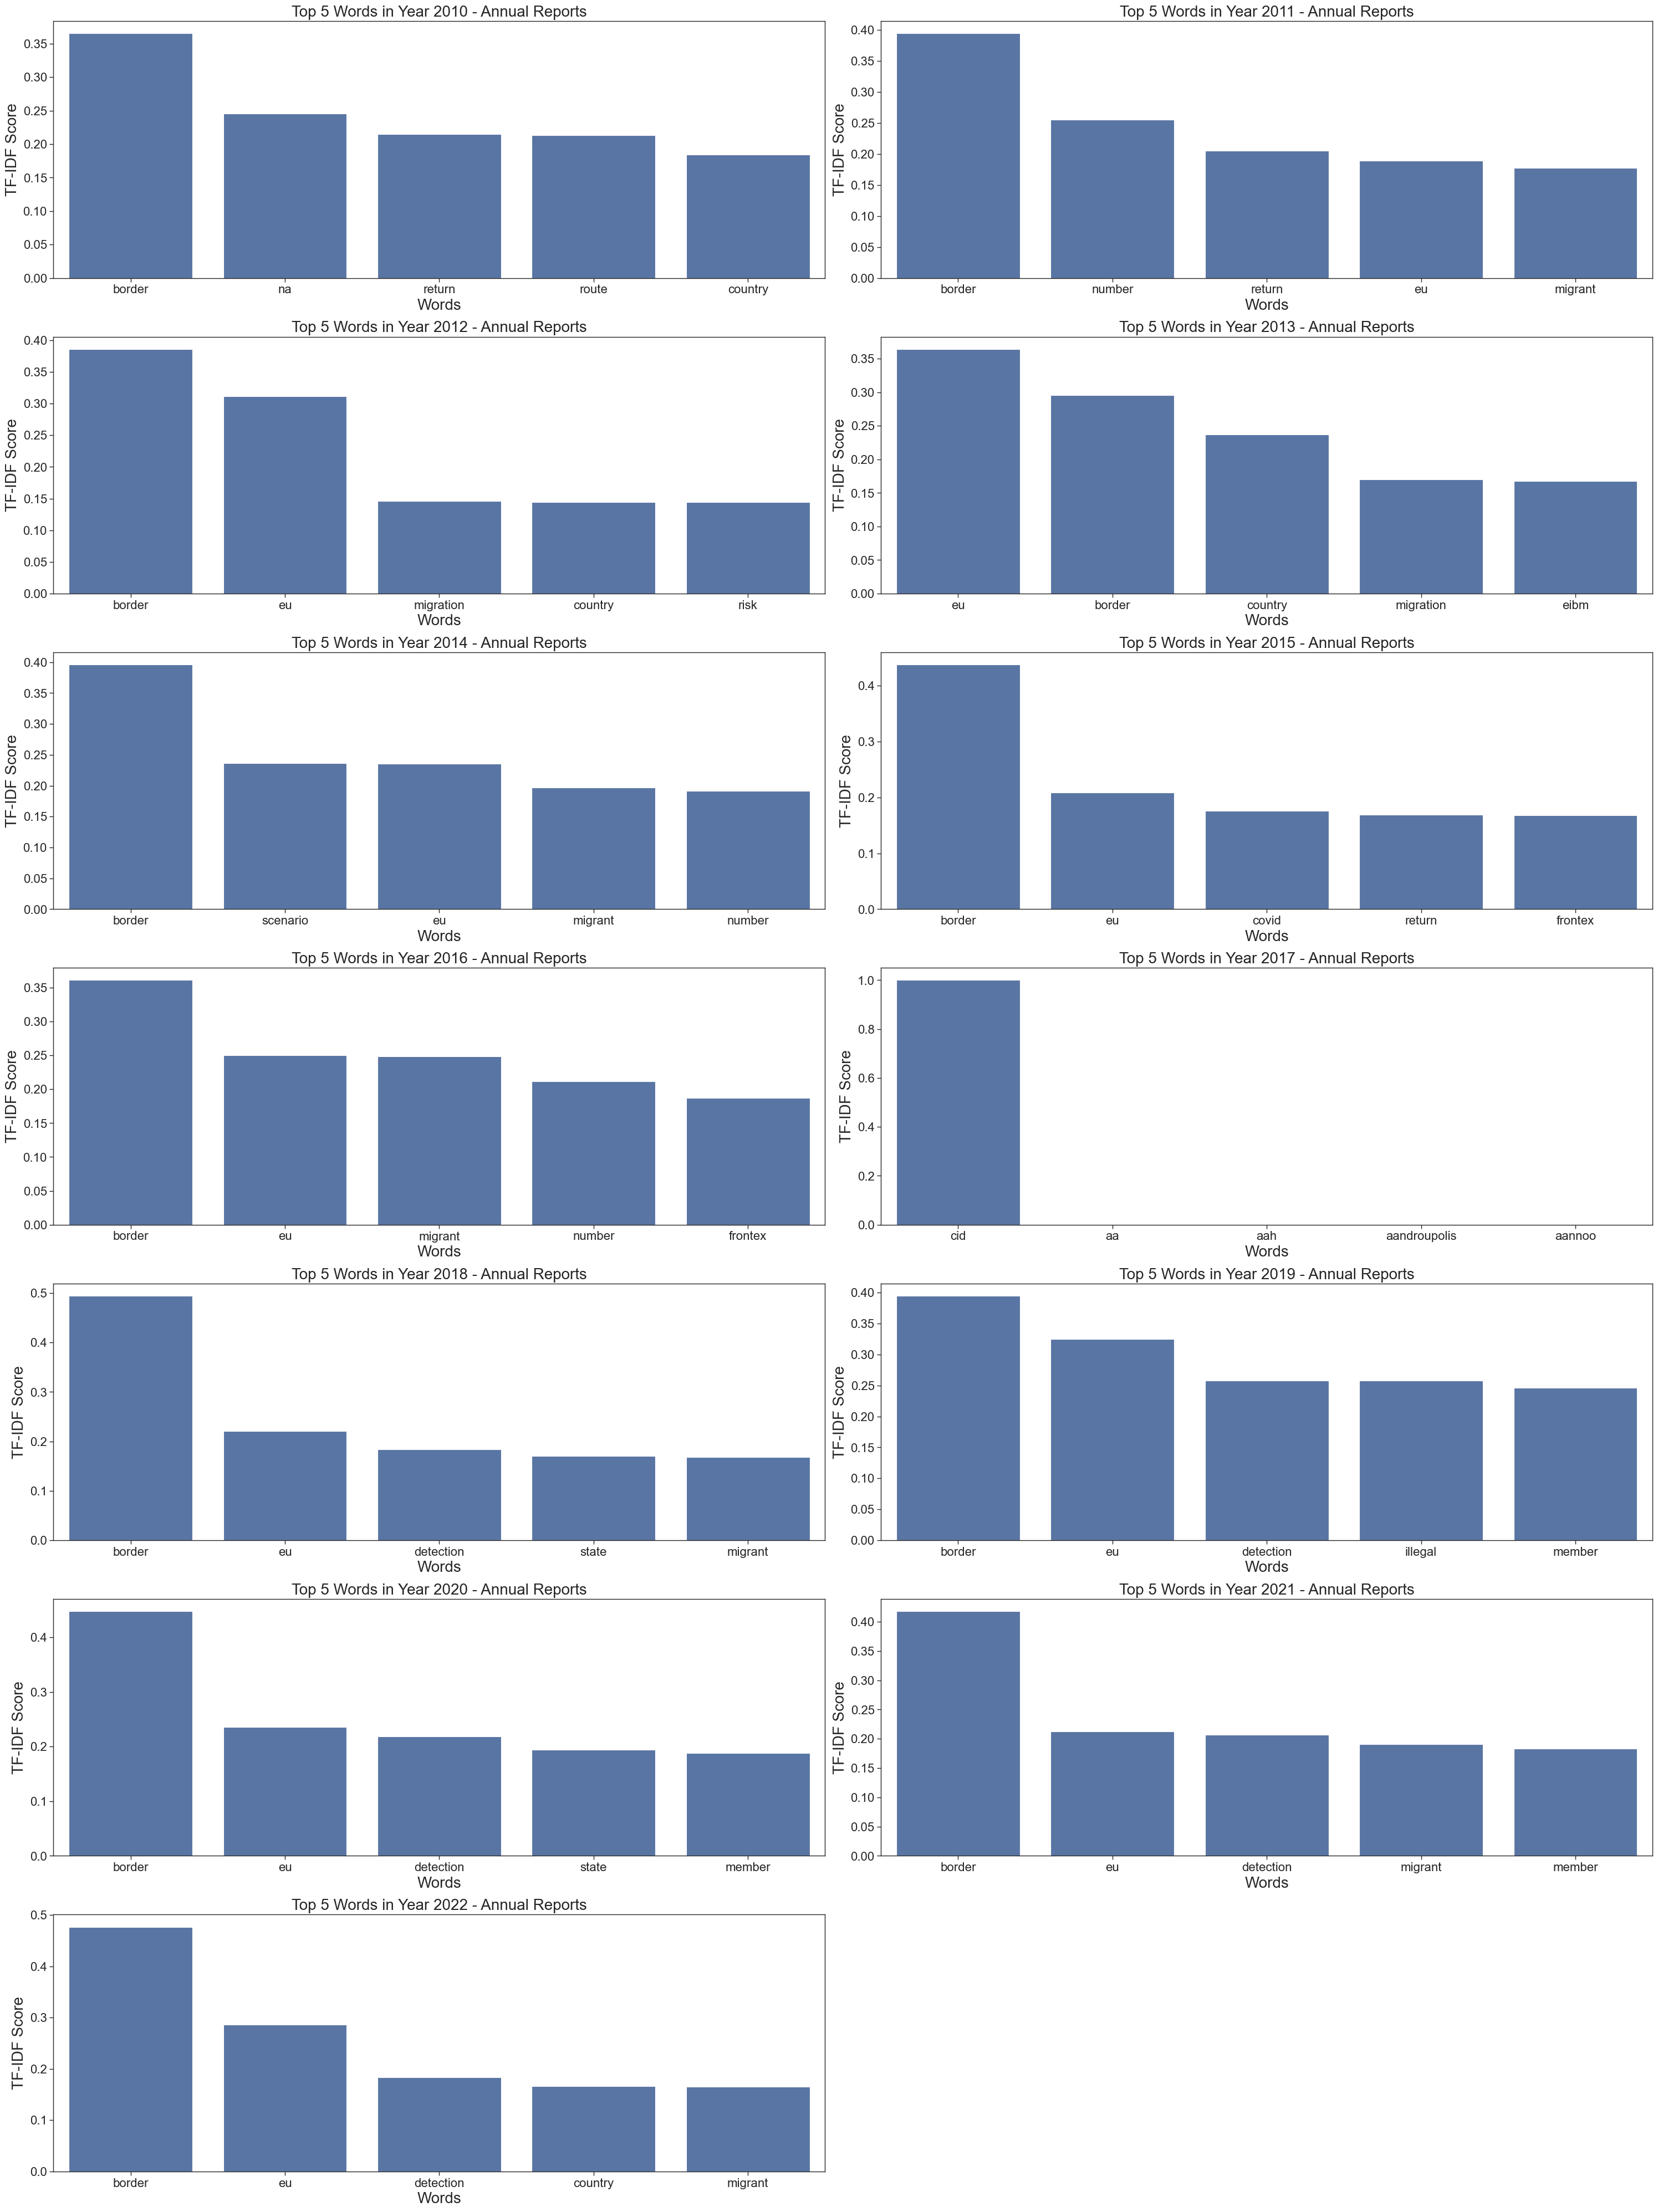

In [29]:
# Prepare an empty DataFrame for all data
all_data_year_annual = pd.DataFrame(columns=['Year', 'Words', 'TF-IDF Score'])
# Group by 'year' and concatenate all TF-IDF tuples
grouped_year_annual = df.groupby('Year')['Top 10 TF-IDF Words'].sum()

# Convert grouped_year.items() to a list of tuples
grouped_year_items_annual = list(grouped_year_annual.items())

# Create a figure to hold the subplots
fig = plt.figure(figsize=(30, 40))

for i, (year, tfidf_tuples_str) in enumerate(grouped_year_items_annual):
    # Use regular expressions to extract tuples from string
    tfidf_tuples_str_list = re.findall(r"\('(.*?)', (.*?)\)", tfidf_tuples_str)
    
    # Convert string representation of score to float
    tfidf_tuples = [(word, float(score)) for word, score in tfidf_tuples_str_list]
    
    # Filter out tuples that do not have 2 elements
    filtered_tuples = [t for t in tfidf_tuples if len(t) == 2]
    
    # Sort by TF-IDF score and get top 5
    top_5 = Counter(dict(filtered_tuples)).most_common(5)
    # Check if top_5 is not empty
    if top_5:
        # Prepare data for seaborn
        words, scores = zip(*top_5)
        data = pd.DataFrame({'Year': [year]*len(words), 'Words': words, 'TF-IDF Score': scores})
        # Append data to all_data
        all_data_year_annual = pd.concat([all_data_year_annual, data], ignore_index=True)
        
        # Create a new subplot in the grid
        ax = fig.add_subplot(7, 2, i+1)
        
        # Plot using seaborn
        sns.barplot(x='Words', y='TF-IDF Score', data=data, ax=ax)
        ax.set_title(f'Top 5 Words in Year {year} - Annual Reports')
        ax.set_xlabel('Words')
        ax.set_ylabel('TF-IDF Score')

plt.tight_layout()
plt.show()

In [30]:
#save plot to results folder
plt.savefig('../results/top_5_tfidf_annual.png')

<Figure size 2000x1000 with 0 Axes>

### Heatmap

In [31]:
#Display settings for heatmap
sns.set(rc={'figure.figsize': (100, 50)})
plt.rcParams.update({'axes.labelsize': 10, 'axes.titlesize': 15,'axes.titlesize': 10, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

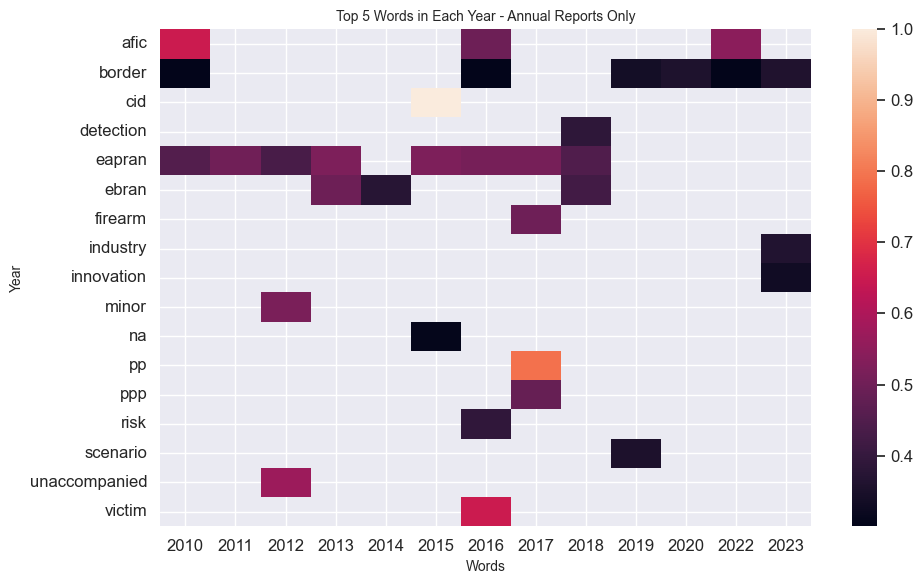

In [32]:
#filter out low-scorig words
all_data_year_annual = all_data_year_annual[all_data_year_annual['TF-IDF Score'] >= 0.3]

# Pivot the data for the heatmap
heatmap_data_annual = all_data_year_annual.pivot(index='Words', columns='Year', values='TF-IDF Score')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data)
plt.title('Top 5 Words in Each Year - Annual Reports Only')
plt.xlabel('Words')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

In [33]:
#save plot to results folder
plt.savefig('../results/heatmap_tfidf_annual.png')

<Figure size 10000x5000 with 0 Axes>

## Keyness Analysis

In [34]:
#calculate term frequency per document
term_frequencies=[Counter(doc) for doc in corpus_annual]

#calculate total term frequencies across all documents
total_term_frequencies=Counter()
for tf in term_frequencies:
    total_term_frequencies.update(tf)

#calculate the size of each document
doc_sizes=[sum(tf.values()) for tf in term_frequencies]

#calculate the total size of the entire corpus
total_size=sum(doc_sizes)

#compute keyness scores for each document
keyness_scores=[]
for i, tf in enumerate(term_frequencies):
    doc_keyness={}
    ref_freqs={term:total_term_frequencies[term]-freq for term, freq in tf.items()}
    ref_size=total_size-doc_sizes[i]
    for term, freq in tf.items():
        ref_freq=ref_freqs.get(term, 0)
        if ref_freq == 0:
            continue
        doc_keyness[term]=compute_keyness(term, freq, ref_freq, doc_sizes[i], ref_size)
    keyness_scores.append(doc_keyness)

/var/folders/fd/qf26p3js3x32_9_qwsb841y80000gn/T/ipykernel_74292/1893606375.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fd/qf26p3js3x32_9_qwsb841y80000gn/T/ipykernel_74292/1893606375.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fd/qf26p3js3x32_9_qwsb841y80000gn/T/ipykernel_74292/1893606375.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fd/qf26p3js3x32_9_qwsb841y80000gn/T/ipykernel_74292/1893606375.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

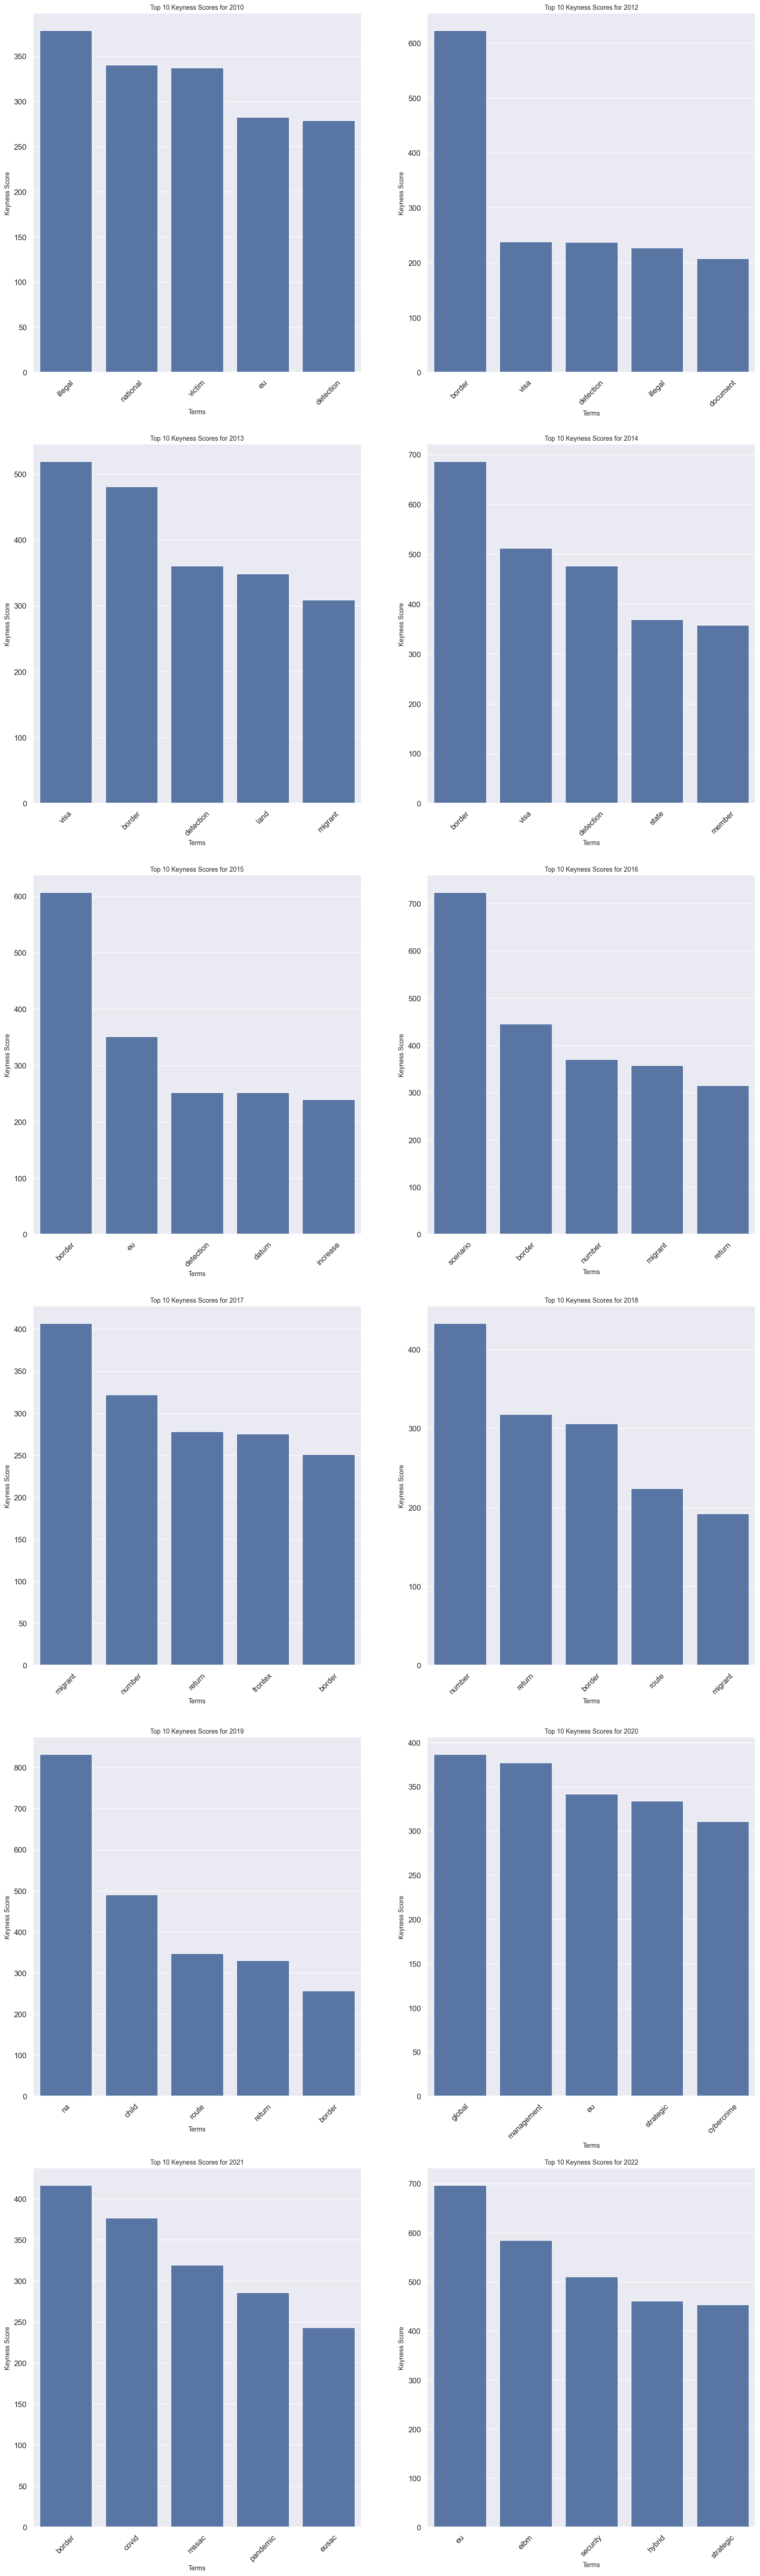

In [35]:
# visulize keyness scores

#extract year of each document
years = [int(re.findall(r'\d{4}', file)[0]) for file in sorted(os.listdir('../data/raw_data_annual'))]
# Create a dictionary with years as keys and keyness score items as values
year_score_dict = dict(zip(years, keyness_scores))
# Sort the dictionary by year
sorted_dict = dict(sorted(year_score_dict.items()))
# Get the years and values out again
sorted_years, sorted_keyness_scores = zip(*sorted_dict.items())

#plot
fig, axes=plt.subplots(6, 2, figsize=(20, 70))
plot_index = 0
for i, scores in enumerate(sorted_keyness_scores):
    sorted_scores=sorted(scores.items(), key=lambda item: item[1], reverse=True)
    if len(sorted_scores) > 0:
        top_terms, top_scores=zip(*sorted_scores[:5])
        ax=axes[plot_index//2, plot_index%2]
        sns.barplot(x=list(top_terms), y=list(top_scores), ax=ax)
        ax.set_title(f'Top 10 Keyness Scores for {sorted_years[i]}')
        ax.set_xlabel('Terms')
        ax.set_ylabel('Keyness Score')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        plot_index += 1
plt.show()

In [37]:
#save plot to results folder
plt.savefig('../results/keyness_scores_annual.png')

<Figure size 10000x5000 with 0 Axes>